[0]	eval-error:0.228365	train-error:0.180005
Multiple eval metrics have been passed: 'train-error' will be used for early stopping.

Will train until train-error hasn't improved in 10 rounds.
[1]	eval-error:0.240385	train-error:0.165979
[2]	eval-error:0.225962	train-error:0.158354
[3]	eval-error:0.225962	train-error:0.152545
[4]	eval-error:0.216346	train-error:0.148819
[5]	eval-error:0.21875	train-error:0.143411
[6]	eval-error:0.216346	train-error:0.140144
[7]	eval-error:0.211538	train-error:0.136838
[8]	eval-error:0.213942	train-error:0.132768
[9]	eval-error:0.204327	train-error:0.12801
[10]	eval-error:0.197115	train-error:0.126233
[11]	eval-error:0.204327	train-error:0.122927
[12]	eval-error:0.211538	train-error:0.120251
[13]	eval-error:0.204327	train-error:0.118283
[14]	eval-error:0.199519	train-error:0.116296
[15]	eval-error:0.201923	train-error:0.114022
[16]	eval-error:0.199519	train-error:0.111805
[17]	eval-error:0.194712	train-error:0.110449
[18]	eval-error:0.197115	train-error:

<IPython.core.display.Javascript object>


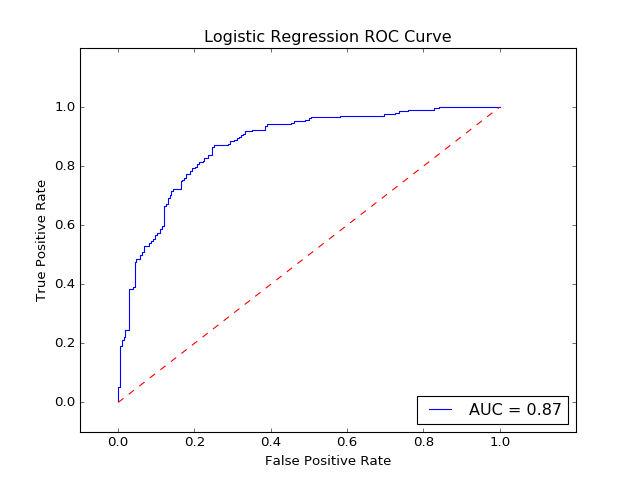

In [4]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, matthews_corrcoef

# read in data
data_dir="/workspace/chipper_data/chipper-0.3.0-data/"
dtrain = xgb.DMatrix(data_dir + "training_data.ll")
dtest = xgb.DMatrix(data_dir + "testing_data.ll")
watchlist  = [(dtest,'eval'), (dtrain,'train')]

# specify parameters via map
param = {'max_depth':5, 'eta':0.3, 'silent':1, 'objective':'binary:logistic'} #, "eval_metric": "auc"}
num_round = 2000
bst = xgb.train(param, dtrain, num_round, watchlist, early_stopping_rounds=10)
# make prediction
preds = bst.predict(dtest)

LR_classification_vector = lambda cutoff: [1 if pred >= cutoff else 0 for pred in preds]

def find_best_mcc():
    best_mcc = 0.0
    best_cutoff = 0.0
    for i in range(1, 100):
        pred_cutoff = i/100.0
        mcc = matthews_corrcoef(dtest.get_label(), LR_classification_vector(pred_cutoff))
        if (mcc > best_mcc):
            best_mcc = mcc
            best_cutoff = pred_cutoff
    return (best_cutoff, best_mcc)

(best_cutoff, best_mcc) = find_best_mcc()
print "** Logistic Regression Report, cutoff= %.2f (MCC=%.3f) **" % (best_cutoff, best_mcc)
print classification_report(dtest.get_label(), LR_classification_vector(best_cutoff))


def print_metrics(name, actual, predicted):
    ((tn, fp), (fn, tp)) = confusion_matrix(actual, predicted)
    sensitivity = 100.0 * tp / (tp + fn)
    specificity = 100.0 * tn / (tn + fp)
    precision = 100.0 * tp / (tp + fp)
    print "%s: sensitivity(recall)=%.1f, specificity=%.1f, precision=%.1f" % (name, sensitivity, specificity, precision)

print_metrics("LR", dtest.get_label(), LR_classification_vector(best_cutoff))

%matplotlib notebook
import matplotlib.pyplot as plt
from sklearn import svm, metrics

fpr, tpr, thresholds = metrics.roc_curve(dtest.get_label(), preds, pos_label=1)
roc_auc = metrics.roc_auc_score(dtest.get_label(), preds, average='macro', sample_weight=None)
plt.title('Logistic Regression ROC Curve')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f'% (roc_auc))
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

#LR: sensitivity(recall)=77.6, specificity=84.8, precision=86.5

In [2]:
#!/usr/bin/python
'''
Created on 1 Apr 2015

@author: Jamie Hall
'''
import pickle
import xgboost as xgb

import numpy as np
from sklearn.cross_validation import KFold, train_test_split
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import load_iris, load_digits, load_boston

rng = np.random.RandomState(31337)

print("Zeros and Ones from the Digits dataset: binary classification")
digits = load_digits(2)
y = digits['target']
X = digits['data']
kf = KFold(y.shape[0], n_folds=2, shuffle=True, random_state=rng)
for train_index, test_index in kf:
    xgb_model = xgb.XGBClassifier().fit(X[train_index],y[train_index])
    predictions = xgb_model.predict(X[test_index])
    actuals = y[test_index]
    print(confusion_matrix(actuals, predictions))

print("Iris: multiclass classification")
iris = load_iris()
y = iris['target']
X = iris['data']
kf = KFold(y.shape[0], n_folds=2, shuffle=True, random_state=rng)
for train_index, test_index in kf:
    xgb_model = xgb.XGBClassifier().fit(X[train_index],y[train_index])
    predictions = xgb_model.predict(X[test_index])
    actuals = y[test_index]
    print(confusion_matrix(actuals, predictions))

print("Boston Housing: regression")
boston = load_boston()
y = boston['target']
X = boston['data']
kf = KFold(y.shape[0], n_folds=2, shuffle=True, random_state=rng)
for train_index, test_index in kf:
    xgb_model = xgb.XGBRegressor().fit(X[train_index],y[train_index])
    predictions = xgb_model.predict(X[test_index])
    actuals = y[test_index]
    print(mean_squared_error(actuals, predictions))

print("Parameter optimization")
y = boston['target']
X = boston['data']
xgb_model = xgb.XGBRegressor()
clf = GridSearchCV(xgb_model,
                   {'max_depth': [2,4,6],
                    'n_estimators': [50,100,200]}, verbose=1)
clf.fit(X,y)
print(clf.best_score_)
print(clf.best_params_)

# The sklearn API models are picklable
print("Pickling sklearn API models")
# must open in binary format to pickle
pickle.dump(clf, open("best_boston.pkl", "wb"))
clf2 = pickle.load(open("best_boston.pkl", "rb"))
print(np.allclose(clf.predict(X), clf2.predict(X)))

# Early-stopping

X = digits['data']
y = digits['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
clf = xgb.XGBClassifier()
clf.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="auc",
        eval_set=[(X_test, y_test)])


/Users/matt/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/matt/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Zeros and Ones from the Digits dataset: binary classification
[[87  0]
 [ 1 92]]
[[91  0]
 [ 3 86]]
Iris: multiclass classification
[[19  0  0]
 [ 0 31  3]
 [ 0  1 21]]
[[31  0  0]
 [ 0 16  0]
 [ 0  3 25]]
Boston Housing: regression
9.86281492905
15.9899625729
Parameter optimization
Fitting 3 folds for each of 9 candidates, totalling 27 fits
0.598487960649
{'n_estimators': 100, 'max_depth': 4}
Pickling sklearn API models
True
[0]	validation_0-auc:0.999497
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.999497
[2]	validation_0-auc:0.999497
[3]	validation_0-auc:0.999749
[4]	validation_0-auc:0.999749
[5]	validation_0-auc:0.999749
[6]	validation_0-auc:0.999749
[7]	validation_0-auc:0.999749
[8]	validation_0-auc:0.999749
[9]	validation_0-auc:0.999749
[10]	validation_0-auc:1
[11]	validation_0-auc:1
[12]	validation_0-auc:1
[13]	validation_0-auc:1
[14]	validation_0-auc:1
[15]	validation_0-auc:1
[16]	validation_0-auc:1
[17]	validation_0-auc:1
[18]	validatio

[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:    3.5s finished


XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [3]:
##
#  This script demonstrate how to access the xgboost eval metrics by using sklearn
##

import xgboost as xgb
import numpy as np
from sklearn.datasets import make_hastie_10_2

X, y = make_hastie_10_2(n_samples=2000, random_state=42)

# Map labels from {-1, 1} to {0, 1}
labels, y = np.unique(y, return_inverse=True)

X_train, X_test = X[:1600], X[1600:]
y_train, y_test = y[:1600], y[1600:]

param_dist = {'objective':'binary:logistic', 'n_estimators':2}

clf = xgb.XGBModel(**param_dist)
# Or you can use: clf = xgb.XGBClassifier(**param_dist)

clf.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)], 
        eval_metric='logloss',
        verbose=True)

# Load evals result by calling the evals_result() function
evals_result = clf.evals_result()

print('Access logloss metric directly from validation_0:')
print(evals_result['validation_0']['logloss'])

print('')
print('Access metrics through a loop:')
for e_name, e_mtrs in evals_result.items():
    print('- {}'.format(e_name))
    for e_mtr_name, e_mtr_vals in e_mtrs.items():
        print('   - {}'.format(e_mtr_name))
        print('      - {}'.format(e_mtr_vals))
 
print('')
print('Access complete dict:')
print(evals_result)

[0]	validation_0-logloss:0.68226	validation_1-logloss:0.68558
[1]	validation_0-logloss:0.672904	validation_1-logloss:0.679176
Access logloss metric directly from validation_0:
[0.68226, 0.672904]

Access metrics through a loop:
- validation_0
   - logloss
      - [0.68226, 0.672904]
- validation_1
   - logloss
      - [0.68558, 0.679176]

Access complete dict:
{u'validation_0': {u'logloss': [0.68226, 0.672904]}, u'validation_1': {u'logloss': [0.68558, 0.679176]}}
